In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from skimage.transform import rotate
import pims, sys
from pathlib import Path
import trackpy as tp
import pandas as pd

In [9]:
@pims.pipeline
def crop_image(frame):
    return frame[:,0:428]
   

# Location of the sample's base folder
base_path = Path(r'C:\Users\jrosk\Dropbox\Warwick\TIRF\29-11-2022\Measurements')

filepath_0 = base_path.joinpath(r'29-Nov-22_Todays_Sample_TIRF_473.tif')
full_roi_stack_0 = pims.open(filepath_0.as_posix())
images_0 = crop_image(full_roi_stack_0)


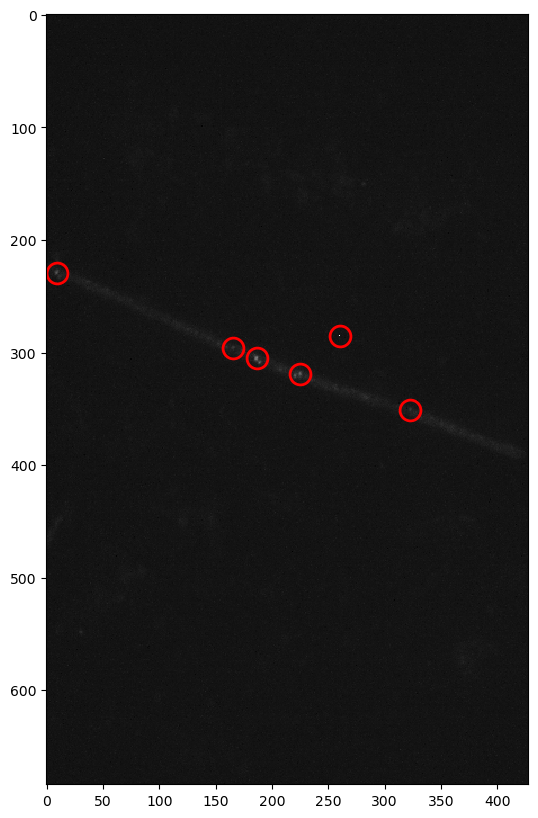

<Axes: >

In [10]:

fig, ax = plt.subplots(1,1, figsize=(10,10))
img_test = images_0[200] # gaussian(images_0[200])#, cutoff_frequency_ratio=0.02)
f = tp.locate(img_test,  diameter=5, minmass=150, separation=20, noise_size=1.0)
tp.annotate(f, img_test)

> 5. Batch process the stack, link particles into trajectories, filter short trajectories

In [11]:
# Version one file
all_particles = tp.batch(images_0,diameter=5, minmass=150, separation=20, noise_size=1.0)


Frame 1825: 4 features


In [12]:
all_linked = tp.link(all_particles, search_range=1, memory=1)
all_linked_filtered = tp.filter_stubs(all_linked, 50)

Frame 1825: 4 trajectories present.


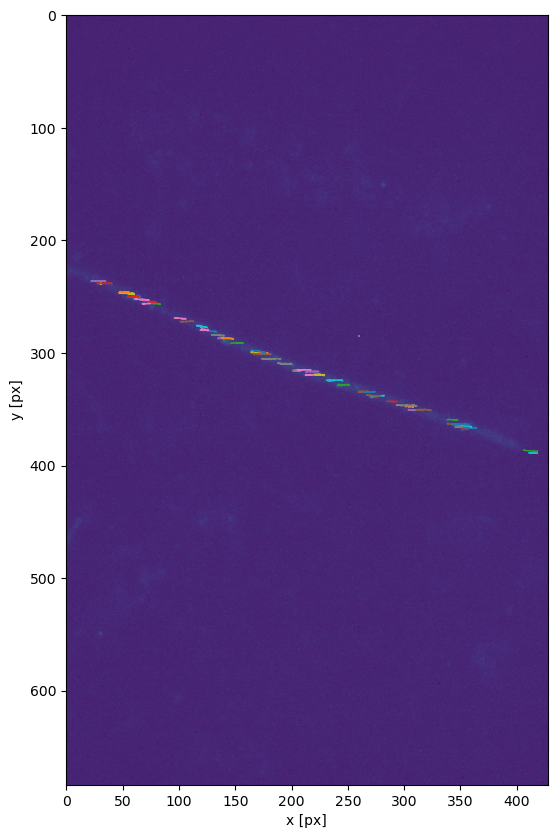

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [13]:
# Inspect results
fig, ax = plt.subplots(1,1, figsize = (10,10))
plt.imshow(images_0[0])
#plt.ylim(500,200)
tp.plot_traj(all_linked_filtered)

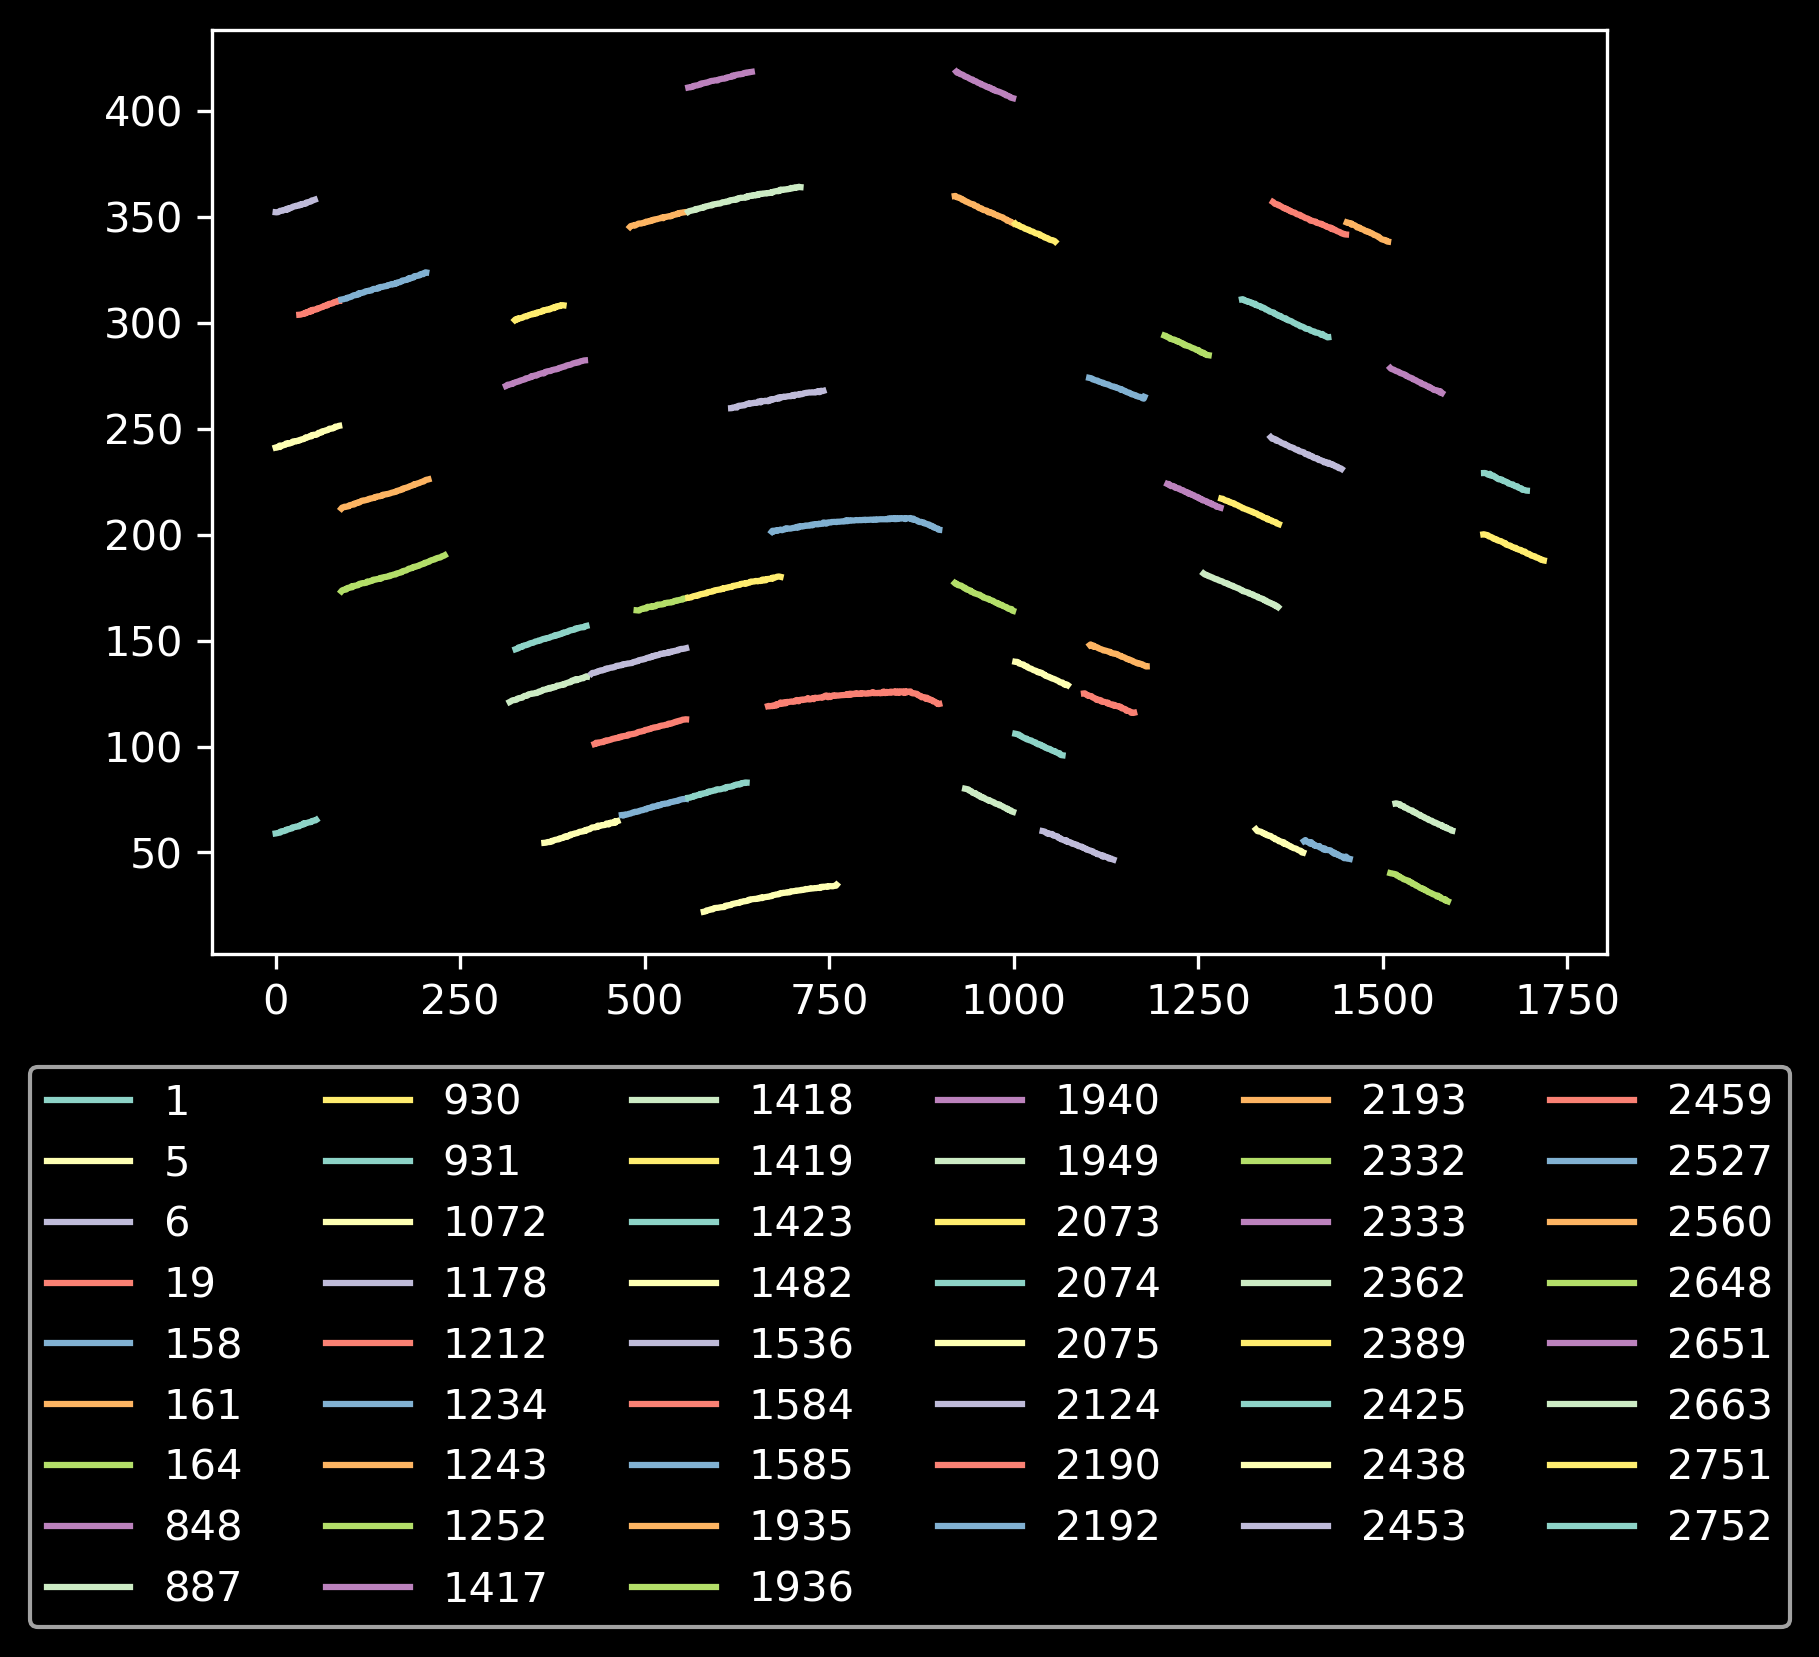

In [14]:
# there will be some artefacts, these don't really change in x coord
all_linked_filtered= all_linked_filtered.groupby('particle').filter(lambda group: group['x'].std() >= 1)


particles = all_linked_filtered['particle'].unique()

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1, figsize = (6,4), dpi=300)
    for particle in particles:
        data_for_particle = all_linked_filtered[(all_linked_filtered['particle'].isin(particles)) 
                                                & (all_linked_filtered['particle']==particle)]
        ax.plot(data_for_particle['frame'].values, data_for_particle['x'].values,'-', label=f'{particle}')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6)
        #ax.annotate(f'{particle}', xy=(data_for_particle['frame'].values[0], data_for_particle['x'].values[0]), xytext=(1, 1),textcoords='offset points')
    #ax.set_ylim(258,263)
    #ax.set_xlim(1800,2500)
        

In [15]:
all_linked_filtered['experiment'] = filepath_0.stem
all_linked_filtered = all_linked_filtered.reset_index(drop=True)
all_linked_filtered.to_csv(f'tracks/{filepath_0.stem}.csv', index=False)